In [ ]:
%load_ext autoreload
%autoreload 2
import numpy as np
import torch 
import os
import glob
from matplotlib import pyplot as plt
import os
import torch
# Cd to code
import os
import sys
os.chdir('/cluster/home/kheuto01/code/prob_diff_topk')
sys.path.append('/cluster/home/kheuto01/code/prob_diff_topk')

from datasets import example_datasets, to_numpy
from torch_models import  MixtureOfTruncNormModel, torch_bpr_uncurried, deterministic_bpr
from torch_perturb.torch_pert_topk import PerturbedTopK
from distributions import QuantizedNormal



In [ ]:
base_dir = '/cluster/tufts/hugheslab/kheuto01/synth_103050_datainit_4000_comp2'
exps = glob.glob(base_dir + '/*')

In [ ]:
seed=360
# tracts/distributions
S=23

# total timepoints
T= 500
K=3

low_set_1_10 = [QuantizedNormal(10, 0.3) for _ in range(10)]
low_set_2_10 = [QuantizedNormal(30, 0.3) for _ in range(10)]
high_set_3 = [QuantizedNormal(50,3) for _ in range(3)]

dist_S = low_set_1_10 + low_set_2_10 + high_set_3

train_y_TS = np.zeros((T, S))
for s, dist in enumerate(dist_S):
    random_state = np.random.RandomState(10000 * seed + s*123456)
    train_y_TS[:, s] = dist.rvs(size=T, random_state=random_state)

In [ ]:
len(exps)

In [14]:
min_nll=1e9
for exp in exps:
    if 'bw0'  in exp or 'nw0' in  exp:
        continue
    nlls = torch.load(exp + '/nlls.pth')
    nlls = [nll.detach().numpy() for nll in nlls]
    this_nll = np.min(nlls)

    if this_nll < min_nll:
        min_nll = this_nll
        best_exp = exp
print(best_exp)
print(min_nll)

/cluster/tufts/hugheslab/kheuto01/synth_103050_datainit_4000_comp2/mu110mu250_bw5000_nw1_sig0.05_ss0.1_th0.99
24239.07454742887


In [ ]:
min_loss=1e9
for exp in exps:
    if 'bw0' in exp or 'nw0' in exp:
        continue
    losses = torch.load(exp + '/losses.pth')
    losses = [loss.detach().numpy() for loss in losses]
    this_loss = np.min(losses)

    if this_loss < min_loss:
        min_loss = this_loss
        best_exp = exp
print(best_exp)
print(min_loss)

In [15]:
max_bpr=0
for exp in exps:
    if 'mu110mu250_bw5000_nw1_sig0.05_ss0.1_th0.99'  not in exp:
        continue
    bprs = torch.load(exp + '/bprs.pth')
    bprs = [bpr.detach().numpy() for bpr in bprs]
    this_bpr = bprs[-1]

    if this_bpr > max_bpr:
        max_bpr = this_bpr
        best_exp = exp
print(best_exp)
print(max_bpr)

/cluster/tufts/hugheslab/kheuto01/synth_103050_datainit_4000_comp2/mu110mu250_bw5000_nw1_sig0.05_ss0.1_th0.99
0.6952062012459879


In [ ]:
def make_report(model, exp, data, title=None):
    model.load_state_dict(torch.load(exp + '/model.pth'))
    losses = torch.load(exp + '/losses.pth')
    bprs = torch.load(exp + '/bprs.pth')
    nlls = torch.load(exp + '/nlls.pth')

    losses = np.array([loss.detach().numpy() for loss in losses])
    bprs = np.array([bpr.detach().numpy() for bpr in bprs])
    nlls = np.array([nll.detach().numpy() for nll in nlls])

    
    # Make an html page with plots of loss, bpr, nll
    fig, ax = plt.subplots(2, 2, figsize=(10, 10))
    ax[0, 0].plot(losses)
    ax[0, 0].set_title('Loss')
    ax[0, 1].plot(bprs)
    ax[0, 1].set_title('BPR')
    ax[1, 0].plot(nlls)
    ax[1, 0].set_title('NLL')
    model.plot_learned(data=train_y_TS, ax=ax[1, 1])
    if title is not None:
        fig.suptitle(title)
    fig.savefig(exp + '/report.png')
    return model
    

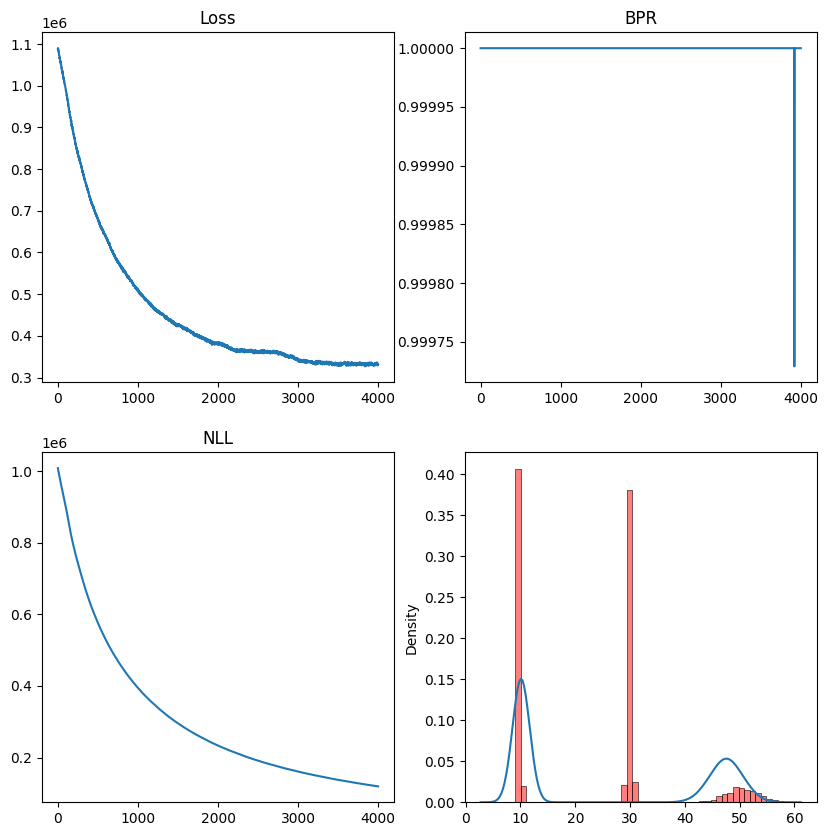

In [12]:
for e,exp in enumerate(exps):
    if 'mu110mu250_bw5000_nw1_sig0.01_ss0.001_th0.99' not in exp:
        continue
    if e % 10 == 0:
        print(f'Processing {e} / {len(exps)}')

    # extract bw number and new number from model name
    bw = exp.split('bw')[1].split('_')[0]
    nw = exp.split('nw')[1].split('_')[0]
    title = f'BPR Weight: {bw}, NLL Weight: {nw}'
    model = MixtureOfTruncNormModel(num_components=2, S=23)
    model = make_report(model, exp, train_y_TS, title=title)

In [ ]:
model.plot_learned(train_y_TS)

In [ ]:
model.plot_learned(train_y_TS)

In [ ]:
# bw500_nw0_ss0.001_th0.55
M_score_func =  200
M_action = 200
val_T = val_y_TS.shape[0]
mix_model = model()
bpr_nll = torch.sum(-mix_model.log_prob( torch.tensor(val_y_TS)))
y_sample_TMS = mix_model.sample((val_T, M_score_func))
y_sample_action_TMS = mix_model.sample((val_T, M_action))

ratio_rating_TMS = y_sample_action_TMS/y_sample_action_TMS.sum(dim=-1, keepdim=True)
ratio_rating_TS =  ratio_rating_TMS.mean(dim=1)
deterministic_bpr_T = deterministic_bpr(ratio_rating_TS, torch.tensor(val_y_TS), K=K)
bpr_det_bpr =torch.mean(deterministic_bpr_T)

In [ ]:
# bw0_nw1_ss0.1_th0.55
M_score_func =  200
M_action = 200
val_T = val_y_TS.shape[0]
mix_model = model()
nll_nll = torch.sum(-mix_model.log_prob( torch.tensor(val_y_TS)))
y_sample_TMS = mix_model.sample((val_T, M_score_func))
y_sample_action_TMS = mix_model.sample((val_T, M_action))

ratio_rating_TMS = y_sample_action_TMS/y_sample_action_TMS.sum(dim=-1, keepdim=True)
ratio_rating_TS =  ratio_rating_TMS.mean(dim=1)
deterministic_bpr_T = deterministic_bpr(ratio_rating_TS, torch.tensor(val_y_TS), K=K)
nll_det_bpr =torch.mean(deterministic_bpr_T)

In [ ]:
#bw5000_nw1_ss0.1_th0.55
M_score_func =  200
M_action = 200
val_T = val_y_TS.shape[0]
mix_model = model()
comb_nll = torch.sum(-mix_model.log_prob( torch.tensor(val_y_TS)))
y_sample_TMS = mix_model.sample((val_T, M_score_func))
y_sample_action_TMS = mix_model.sample((val_T, M_action))

ratio_rating_TMS = y_sample_action_TMS/y_sample_action_TMS.sum(dim=-1, keepdim=True)
ratio_rating_TS =  ratio_rating_TMS.mean(dim=1)
deterministic_bpr_T = deterministic_bpr(ratio_rating_TS, torch.tensor(val_y_TS), K=K)
comb_det_bpr =torch.mean(deterministic_bpr_T)

In [ ]:
plt.plot([comb_det_bpr.detach()], [-comb_nll.detach()], 'ko', label='Optimize Both')
plt.plot([nll_det_bpr.detach()], [-nll_nll.detach()], 'bo', label='Optimize NLL')
plt.plot([bpr_det_bpr.detach()], [-bpr_nll.detach()], 'go', label='Optimize BPR')
plt.legend()
plt.xlabel('BPR')
plt.ylabel('Log Likelihood')

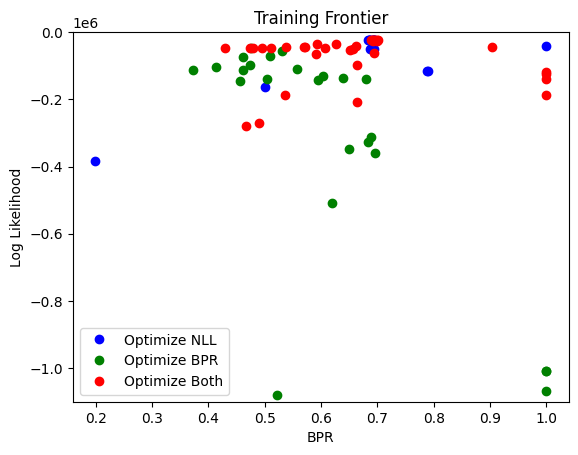

In [30]:
nll_bprs = []
nll_nlls = []
bpr_bprs = []
bpr_nlls = []
both_bprs = []
both_nlls = []

for e,exp in enumerate(exps):
    losses = torch.load(exp + '/losses.pth')
    bprs = torch.load(exp + '/bprs.pth')
    nlls = torch.load(exp + '/nlls.pth')

    losses = np.array([loss.detach().numpy() for loss in losses])
    bprs = np.array([bpr.detach().numpy() for bpr in bprs])
    nlls = np.array([nll.detach().numpy() for nll in nlls])
    bw = exp.split('bw')[1].split('_')[0]
    nw = exp.split('nw')[1].split('_')[0]


    if bw=='0':
        nll_bprs.append(bprs[-1])
        nll_nlls.append(-nlls[-1])
    elif nw=='0':
        bpr_bprs.append(bprs[-1])
        bpr_nlls.append(-nlls[-1])
    else:
        both_bprs.append(bprs[-1])
        both_nlls.append(-nlls[-1])

plt.plot(nll_bprs, nll_nlls, 'bo', label='Optimize NLL')
plt.plot(bpr_bprs, bpr_nlls, 'go', label='Optimize BPR')
plt.plot(both_bprs, both_nlls, 'ro', label='Optimize Both')
plt.xlabel('BPR')
plt.ylabel('Log Likelihood')
# set ylimits to -100000 to 0
plt.ylim(-1100000, 0)
plt.title('Training Frontier')
plt.legend()
    

In [19]:
exps

['/cluster/tufts/hugheslab/kheuto01/synth_103050_datainit_4000_comp2/mu110mu230_bw0_nw1_sig0.01_ss0.001_th0.99',
 '/cluster/tufts/hugheslab/kheuto01/synth_103050_datainit_4000_comp2/mu110mu230_bw0_nw1_sig0.01_ss0.1_th0.99',
 '/cluster/tufts/hugheslab/kheuto01/synth_103050_datainit_4000_comp2/mu110mu230_bw0_nw1_sig0.01_ss0.5_th0.99',
 '/cluster/tufts/hugheslab/kheuto01/synth_103050_datainit_4000_comp2/mu110mu230_bw0_nw1_sig0.05_ss0.001_th0.99',
 '/cluster/tufts/hugheslab/kheuto01/synth_103050_datainit_4000_comp2/mu110mu230_bw0_nw1_sig0.05_ss0.1_th0.99',
 '/cluster/tufts/hugheslab/kheuto01/synth_103050_datainit_4000_comp2/mu110mu230_bw0_nw1_sig0.05_ss0.5_th0.99',
 '/cluster/tufts/hugheslab/kheuto01/synth_103050_datainit_4000_comp2/mu110mu230_bw100000_nw0_sig0.01_ss0.001_th0.99',
 '/cluster/tufts/hugheslab/kheuto01/synth_103050_datainit_4000_comp2/mu110mu230_bw100000_nw0_sig0.01_ss0.1_th0.99',
 '/cluster/tufts/hugheslab/kheuto01/synth_103050_datainit_4000_comp2/mu110mu230_bw100000_nw0_sig